In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy.modflow as mf
import flopy.utils as fu
import shutil
import json
from scipy.misc import imresize

%matplotlib inline

In [2]:
central_base_model_path = os.path.join('central-base-model')
landelino_model_path = os.path.join('landelino-model')

In [3]:
if os.path.exists(landelino_model_path):
    shutil.rmtree(landelino_model_path)
    
if not os.path.exists(landelino_model_path):
    os.makedirs(landelino_model_path)

In [4]:
extractRowsBetween = [6, 20]
extractColsBetween = [49, 60]
scaling_factor = 10

def scale(factor, array):
    if (len(array.shape) == 2):
        layer = []
        for row in array:
            newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
            for _ in range(factor): # or xrange if you are on 2.X
                layer.append(newRow)

        return layer
    
    if (len(array.shape) == 3):
        layers = []
        for layerData in array:
            layer = []
            for row in layerData:
                newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
                for _ in range(factor): # or xrange if you are on 2.X
                    layer.append(newRow)

            layers.append(layer)

        return layers

### Setup mf-package

In [5]:
modelname = 'landelina'
ml = mf.Modflow(modelname=modelname, exe_name='mf2005', version='mf2005', model_ws=landelino_model_path)

### Setup dis-package

In [6]:
nlay = 7
nrow = 140
ncol = 110

area_width_y = 1400
area_width_x = 1100

delc = area_width_x/ncol
delr = area_width_y/nrow

nper = 1

In [7]:
cbm = mf.Modflow.load("model.nam", model_ws=central_base_model_path, verbose=False, check=False, exe_name="mf2000")

In [8]:
top = cbm.dis.top.array[extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
top = scale(scaling_factor, top)

botm = cbm.dis.botm.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
botm = scale(scaling_factor, botm)

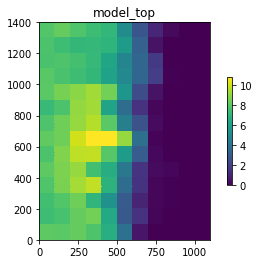

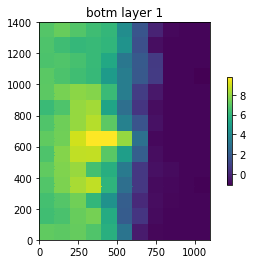

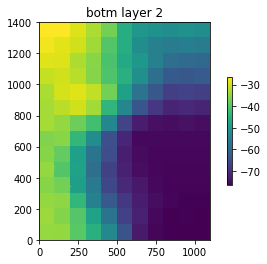

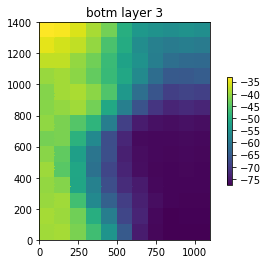

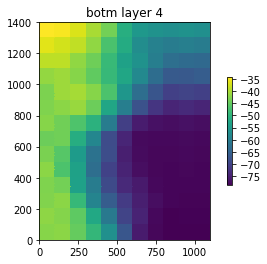

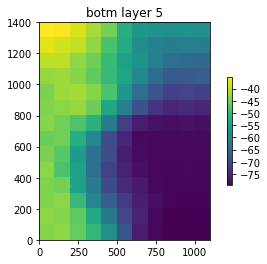

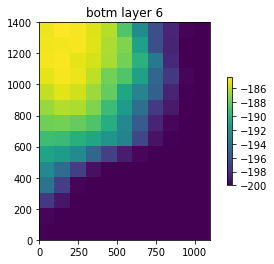

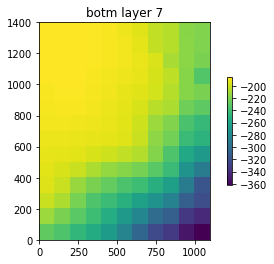

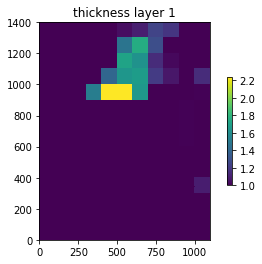

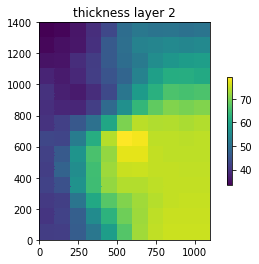

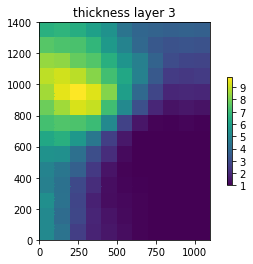

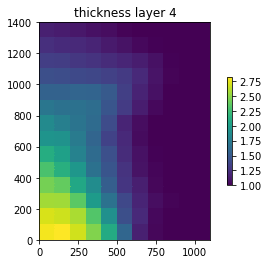

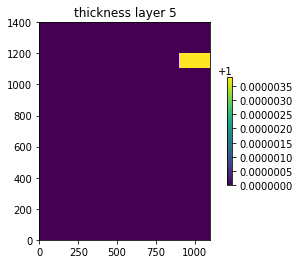

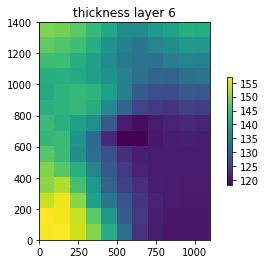

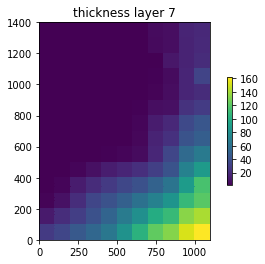

In [9]:
dis = mf.ModflowDis(
    ml, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=False
)

dis.plot()

### Setup Basic-Package

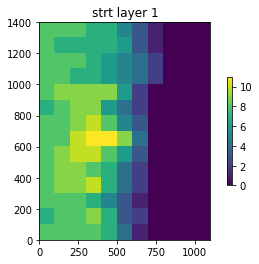

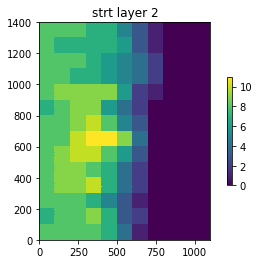

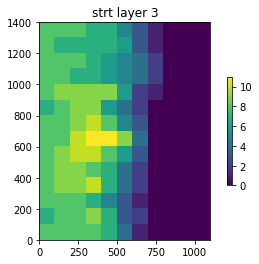

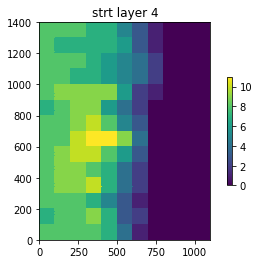

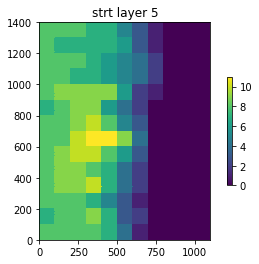

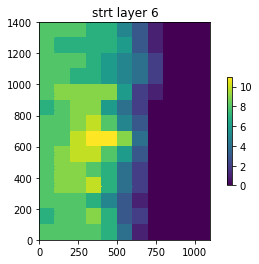

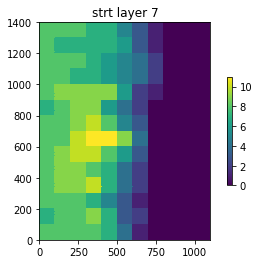

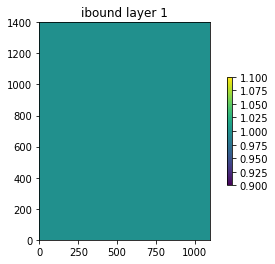

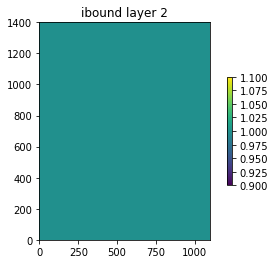

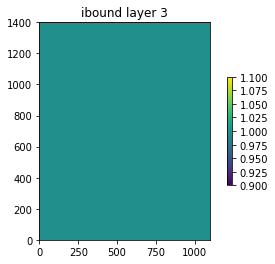

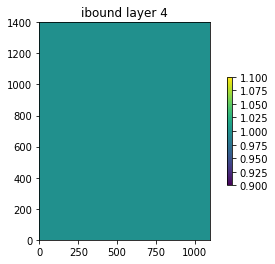

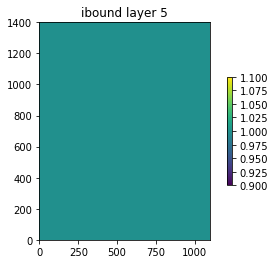

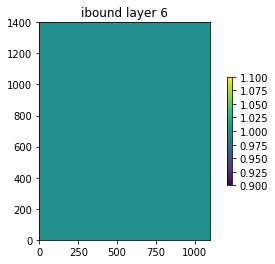

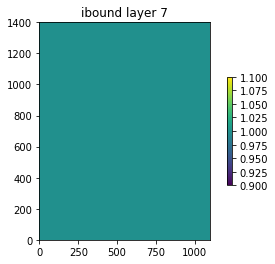

In [10]:
ibound = 1
strt = cbm.bas6.strt.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
strt = scale(scaling_factor, strt)
bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
bas.plot()

### Setup General Head Boundaries

lets take the start values here and extract the values for each border and layer

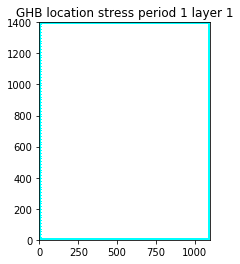

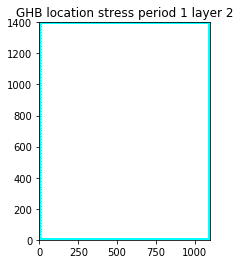

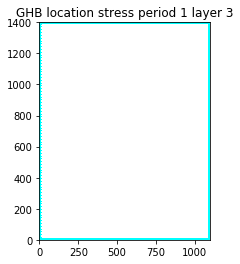

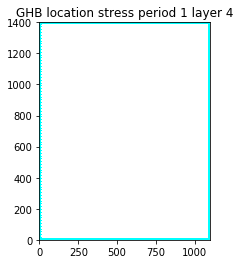

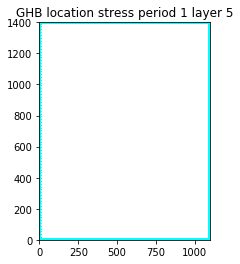

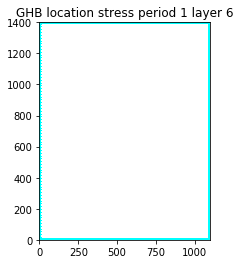

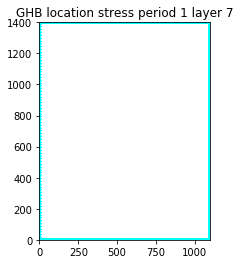

In [11]:
#  [lay, row, col, stage, cond]
mask_arr = np.zeros((nlay, nrow, ncol))
mask_arr[:, 0, :] = 1
mask_arr[:, -1, :] = 1
mask_arr[:, :, 0] = 1
mask_arr[:, :, -1] = 1

ghb_spd = {0: []}
for layer_id in range(nlay):
    for row_id in range(nrow):
        for col_id in range(ncol):
            if mask_arr[layer_id][row_id][col_id] == 1:
                ghb_spd[0].append([layer_id, row_id, col_id, strt[layer_id][row_id][col_id], 200])

ghb = mf.ModflowGhb(ml, stress_period_data=ghb_spd)
ghb.plot()

### Setup Recharge

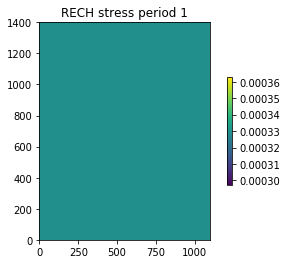

In [12]:
rech = {}
rech[0] = 0.00033
rch = mf.ModflowRch(ml, rech=rech)

rch.plot()

### Setup the well boundary

Add wells here. Load from CSV and calculate layer.

In [13]:
#welSp = {0: []}
#wel = mf.ModflowWel(ml, stress_period_data=welSp)
#wel.plot()

### Setup Flow-Package

In [14]:
lpf = mf.ModflowLpf(ml, hk=100, vka=0.1)

### Setup Solver Package and Output-control with defaults

In [15]:
pcg = mf.ModflowPcg(ml)
oc = mf.ModflowOc(ml)

In [16]:
ml.write_input()
ml.run_model()

FloPy is using the following executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: landelina.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/11/15 15:43:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/11/15 15:43:29
 Elapsed run time:  0.557 Seconds

  Normal termination of simulation


(True, [])

### Read output file

In [17]:
hds = fu.HeadFile(os.path.join(landelino_model_path, modelname + '.hds'))

### Plot output file

In [18]:
hds.plot(totim=times[-1], colorbar=True, masked_values=[1e30])

NameError: name 'times' is not defined